# Differential gene expression analysis - data pre-processing for pseudobulk
Using the data set Misharin.

## 1. Environment setup

In [15]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import anndata

sc.settings.verbosity = 0

## 2. Preparing the dataset

In [16]:
adata = sc.read("/home/sch/schonner/MaPra/schiller_whl_for_merge.h5ad")
adata

AnnData object with n_obs × n_vars = 24071 × 23400
    obs: 'author_annotation', 'batch', 'condition', 'timepoint', 'manual_celltype_annotation', 'author_annotation_coarse'

### We will need label (which contains the condition label), replicate and cell_type columns of the .obs

---> condition, batch and manual_celltype_annotation in this data set

In [17]:
adata.obs[:5]

,author_annotation,batch,condition,timepoint,manual_celltype_annotation,author_annotation_coarse
0,T-lymphocytes,muc4169,healthy,d14,undefined,T_cells
1,AT2 cells,muc4169,healthy,d14,AT2,alv_epithelium
2,VECs,muc4169,healthy,d14,Endothelial,endothelial_cells
3,AT2 cells,muc4169,healthy,d14,AT2,alv_epithelium
4,T-lymphocytes,muc4169,healthy,d14,undefined,T_cells


### We will need to work with raw counts so we check that .X indeed contains raw counts and put them into the counts layer of our AnnData object.

In [18]:
np.max(adata.X)

1573.0

In [19]:
adata.layers["counts"] = adata.X.copy()

In [20]:
print(len(adata[adata.obs["condition"] == "control"].obs["batch"]))
print(len(adata[adata.obs["condition"] == "asbestos"].obs["batch"]))

0
0


### Rudimentary quality control (taken from the book chapter):

In [21]:
sc.pp.filter_cells(adata, min_genes=200)   # filter cells which have less than 200 genes
sc.pp.filter_genes(adata, min_cells=3)     # filter genes which were found in less than 3 cells
adata

AnnData object with n_obs × n_vars = 24071 × 18031
    obs: 'author_annotation', 'batch', 'condition', 'timepoint', 'manual_celltype_annotation', 'author_annotation_coarse', 'n_genes'
    var: 'n_cells'
    layers: 'counts'

## 3. Pseudobulk

In [22]:
# create patient-condition combinations -> not really possible for this data set
adata.obs["sample"] = [
    f"{rep}_{l}" for rep, l in zip(adata.obs["batch"], adata.obs["condition"])
]

In [23]:
# clean up the cell type names
adata.obs["manual_celltype_annotation"] = [ct.replace(" ", "_") for ct in adata.obs["manual_celltype_annotation"]]
adata.obs["manual_celltype_annotation"] = [ct.replace("+", "") for ct in adata.obs["manual_celltype_annotation"]]
adata.obs["manual_celltype_annotation"] = [ct.replace(".", "_") for ct in adata.obs["manual_celltype_annotation"]]

In [24]:
# set categorical metadata to be indeed categorical to create pseudobulks 
adata.obs['batch'] = adata.obs["batch"].astype(str)
adata.obs['condition'] = adata.obs["condition"].astype(str)
adata.obs['sample'] = adata.obs["sample"].astype(str)
adata.obs['manual_celltype_annotation'] = adata.obs["manual_celltype_annotation"].astype(str)

adata.obs["batch"] = adata.obs["batch"].astype("category")
adata.obs["condition"] = adata.obs["condition"].astype("category")
adata.obs["sample"] = adata.obs["sample"].astype("category")
adata.obs["manual_celltype_annotation"] = adata.obs["manual_celltype_annotation"].astype("category")

In [25]:
adata.obs[:5]

,author_annotation,batch,condition,timepoint,manual_celltype_annotation,author_annotation_coarse,n_genes,sample
0,T-lymphocytes,muc4169,healthy,d14,undefined,T_cells,288,muc4169_healthy
1,AT2 cells,muc4169,healthy,d14,AT2,alv_epithelium,784,muc4169_healthy
2,VECs,muc4169,healthy,d14,Endothelial,endothelial_cells,333,muc4169_healthy
3,AT2 cells,muc4169,healthy,d14,AT2,alv_epithelium,255,muc4169_healthy
4,T-lymphocytes,muc4169,healthy,d14,undefined,T_cells,389,muc4169_healthy


In [26]:
adata.obs.dtypes

author_annotation             category
batch                         category
condition                     category
timepoint                     category
manual_celltype_annotation    category
author_annotation_coarse      category
n_genes                          int64
sample                        category
dtype: object

### Define the function we need to aggregate single cells into pseudo-replicates:

In [27]:
NUM_OF_CELL_PER_DONOR = 30   # TODO: can this number be used?


def aggregate_and_filter(
    adata,
    cell_identity,
    donor_key="sample",
    condition_key="condition",
    cell_identity_key="manual_celltype_annotation",
    obs_to_keep=[],  # which additional metadata to keep, e.g. gender, age, etc.
    replicates_per_patient=1,
):
    # subset adata to the given cell identity
    adata_cell_pop = adata[adata.obs[cell_identity_key] == cell_identity].copy()
    # check which donors to keep according to the number of cells specified with NUM_OF_CELL_PER_DONOR
    size_by_donor = adata_cell_pop.obs.groupby([donor_key]).size()
    donors_to_drop = [
        donor
        for donor in size_by_donor.index
        if size_by_donor[donor] <= NUM_OF_CELL_PER_DONOR
    ]
    if len(donors_to_drop) > 0:
        print("Dropping the following samples:")
        print(donors_to_drop)
    df = pd.DataFrame(columns=[*adata_cell_pop.var_names, *obs_to_keep])

    adata_cell_pop.obs[donor_key] = adata_cell_pop.obs[donor_key].astype("category")
    for i, donor in enumerate(donors := adata_cell_pop.obs[donor_key].cat.categories):
        print(f"\tProcessing donor {i+1} out of {len(donors)}...", end="\r")
        if donor not in donors_to_drop:
            adata_donor = adata_cell_pop[adata_cell_pop.obs[donor_key] == donor]
            # create replicates for each donor
            indices = list(adata_donor.obs_names)
            random.shuffle(indices)
            indices = np.array_split(np.array(indices), replicates_per_patient)
            for i, rep_idx in enumerate(indices):
                adata_replicate = adata_donor[rep_idx]
                # specify how to aggregate: sum gene expression for each gene for each donor and also keep the condition information
                agg_dict = {gene: "sum" for gene in adata_replicate.var_names}
                for obs in obs_to_keep:
                    agg_dict[obs] = "first"
                # create a df with all genes, donor and condition info
                df_donor = pd.DataFrame(adata_replicate.X.A)
                df_donor.index = adata_replicate.obs_names
                df_donor.columns = adata_replicate.var_names
                df_donor = df_donor.join(adata_replicate.obs[obs_to_keep])
                # aggregate
                df_donor = df_donor.groupby(donor_key).agg(agg_dict)
                df_donor[donor_key] = donor
                df.loc[f"donor_{donor}_{i}"] = df_donor.loc[donor]
    print("\n")
    # create AnnData object from the df
    adata_cell_pop = sc.AnnData(
        df[adata_cell_pop.var_names], obs=df.drop(columns=adata_cell_pop.var_names)
    )
    return adata_cell_pop

### Create the AnnData object with pseudobulks:

In [28]:
obs_to_keep = ["condition", "manual_celltype_annotation", "batch", "sample", "author_annotation"]

In [29]:
adata.X = adata.layers["counts"].copy()

In [30]:
adata.obs["manual_celltype_annotation"].cat.categories

Index(['AT1', 'AT2', 'Alveolar_fibroblast', 'Dendritic', 'Endothelial',
       'Myofibroblasts', 'Neutrophils', 'undefined'],
      dtype='object')

In [31]:
# process first cell type separately...
cell_type = adata.obs["manual_celltype_annotation"].cat.categories[0]
print(
    f'Processing {cell_type} (1 out of {len(adata.obs["manual_celltype_annotation"].cat.categories)})...'
)
adata_pb = aggregate_and_filter(adata, cell_type, obs_to_keep=obs_to_keep)
for i, cell_type in enumerate(adata.obs["manual_celltype_annotation"].cat.categories[1:]):
    print(
        f'Processing {cell_type} ({i+2} out of {len(adata.obs["manual_celltype_annotation"].cat.categories)})...'
    )
    adata_cell_type = aggregate_and_filter(adata, cell_type, obs_to_keep=obs_to_keep)
    adata_pb = anndata.concat([adata_pb, adata_cell_type])   # --> adata_pb.concatenate(adata_cell_type) does not work!

Processing AT1 (1 out of 8)...
Dropping the following samples:
['muc4169_healthy', 'muc4173_healthy', 'muc4631_bleo', 'muc4632_bleo', 'muc4644_healthy', 'muc4653_bleo']
	Processing donor 28 out of 28...

Processing AT2 (2 out of 8)...
Dropping the following samples:
['muc4631_bleo', 'muc4632_bleo', 'muc4635_bleo', 'muc4644_healthy', 'muc4646_bleo', 'muc4647_bleo', 'muc4653_bleo', 'muc4655_bleo', 'muc4656_bleo']
	Processing donor 28 out of 28...

Processing Alveolar_fibroblast (3 out of 8)...
Dropping the following samples:
['muc4169_healthy', 'muc4171_bleo', 'muc4172_healthy', 'muc4631_bleo', 'muc4632_bleo', 'muc4633_bleo', 'muc4634_bleo', 'muc4636_bleo', 'muc4637_bleo', 'muc4640_healthy', 'muc4643_bleo', 'muc4644_healthy', 'muc4645_bleo', 'muc4646_bleo', 'muc4653_bleo', 'muc4655_bleo']
	Processing donor 28 out of 28...

Processing Dendritic (4 out of 8)...
Dropping the following samples:
['muc4644_healthy', 'muc4653_bleo', 'muc4657_healthy']
	Processing donor 28 out of 28...

Processi

### Saving data and first visualizations:

In [32]:
adata_pb.layers['counts'] = adata_pb.X.copy()

In [33]:
sc.pp.normalize_total(adata_pb, target_sum=1e6)
sc.pp.log1p(adata_pb)
sc.pp.pca(adata_pb)

In [34]:
adata_pb.obs["lib_size"] = np.sum(adata_pb.layers["counts"], axis=1)
adata_pb.obs["lib_size"] = adata_pb.obs["lib_size"].astype(float)   # --> not in example but important
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"])

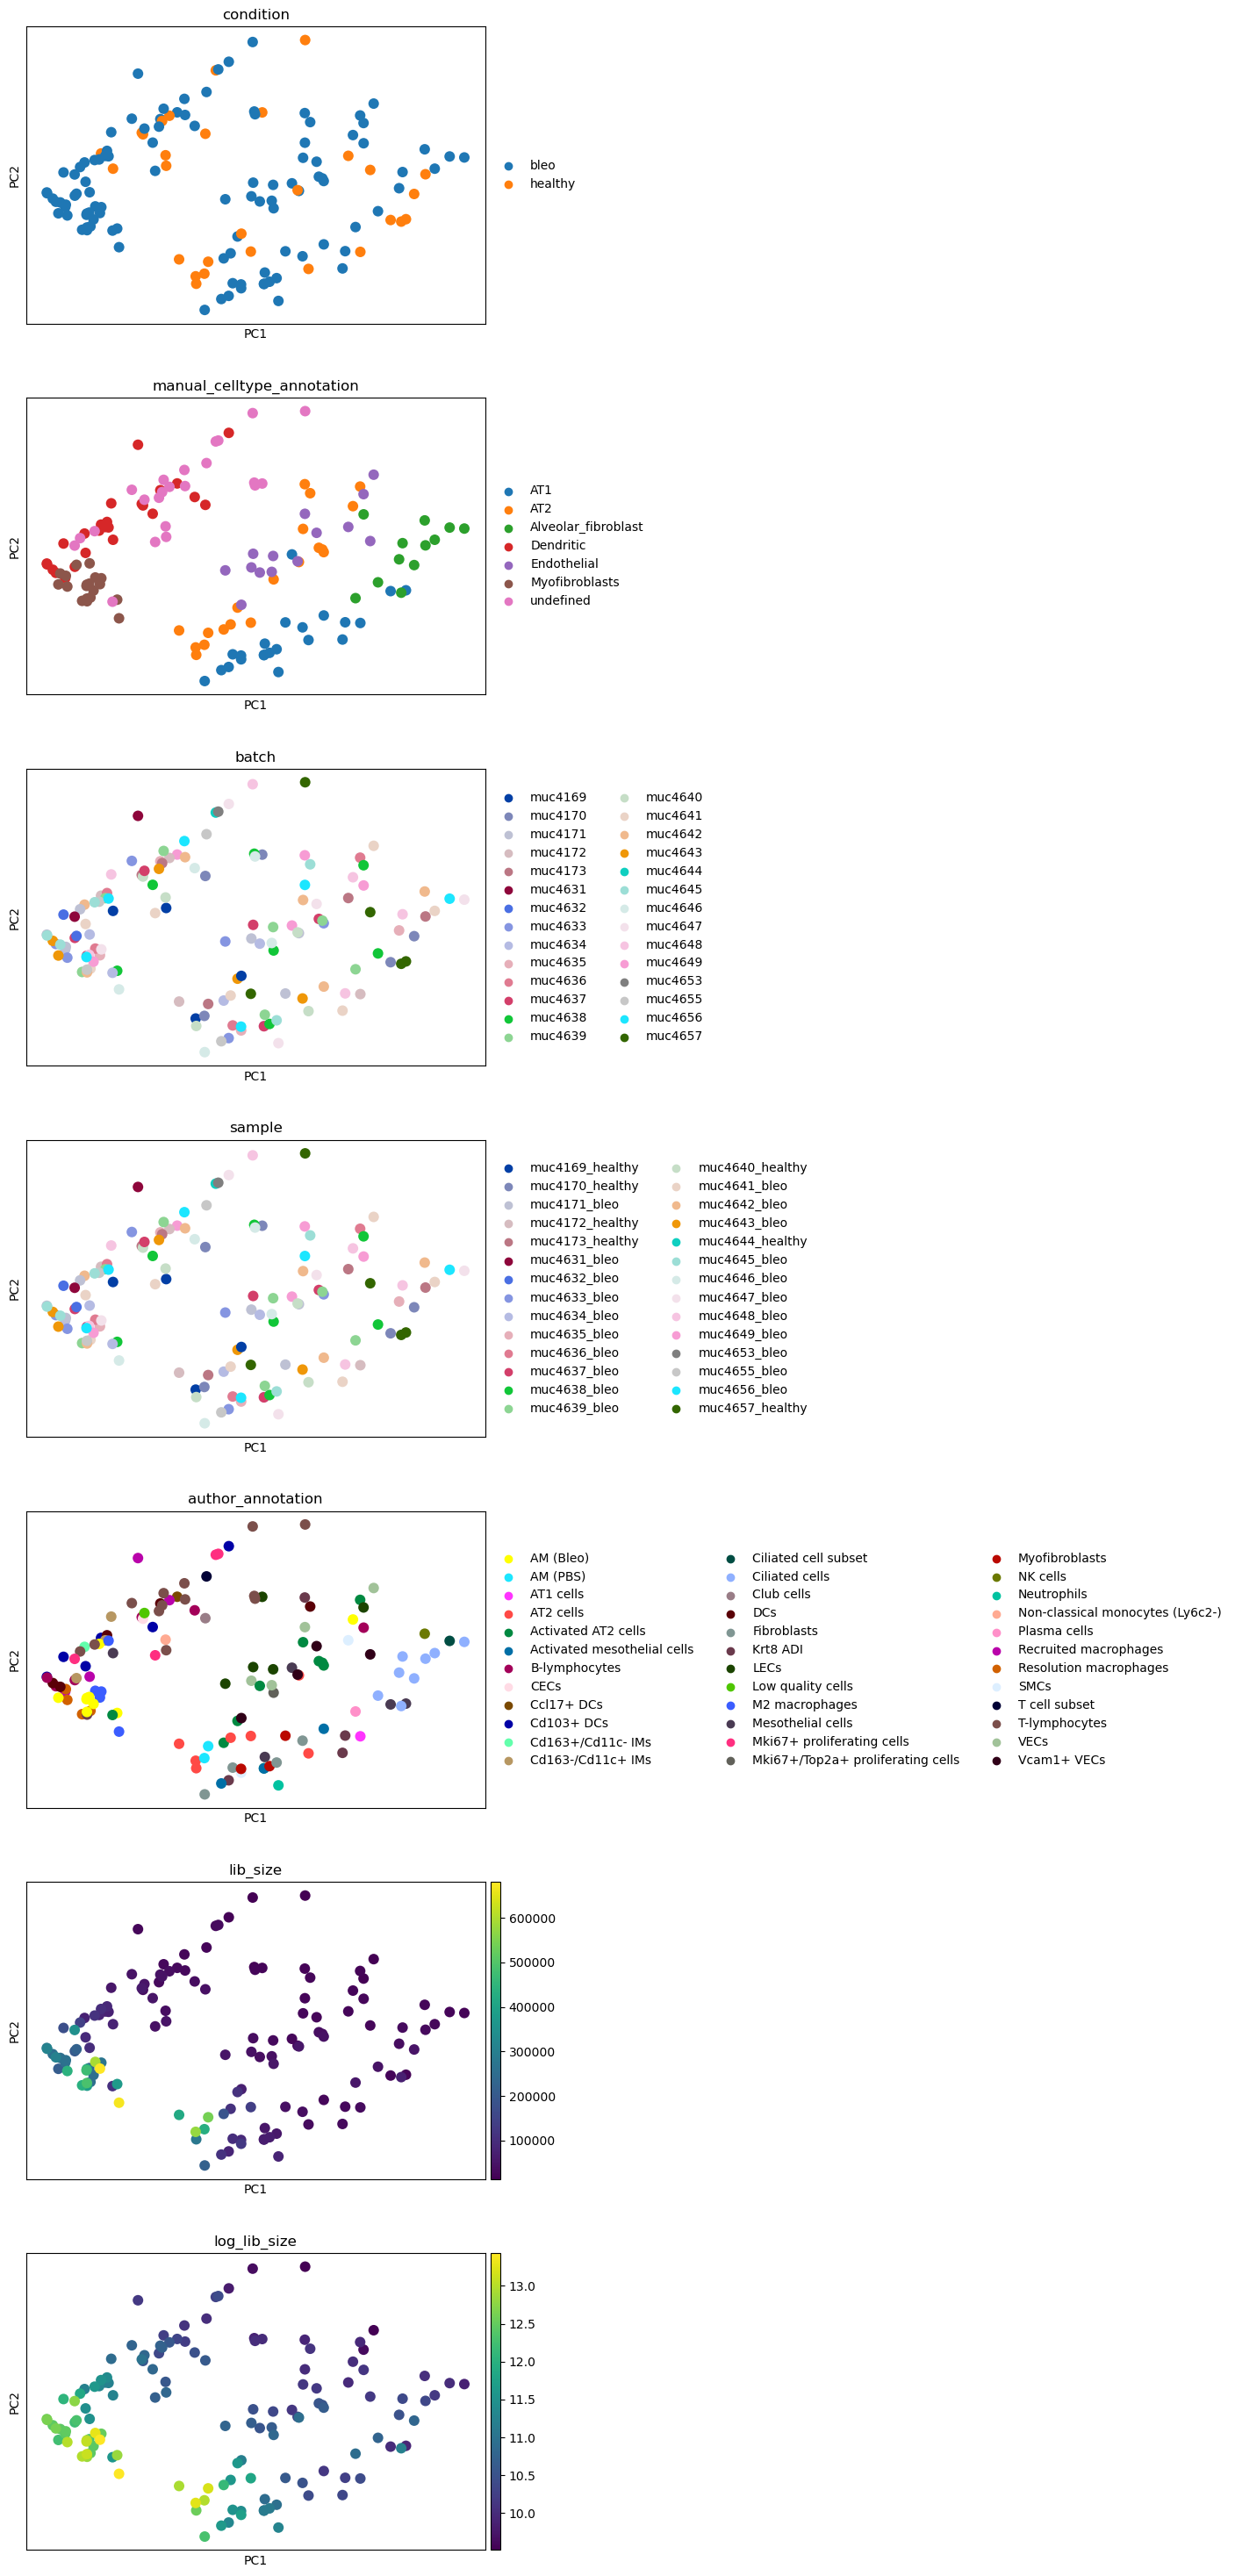

In [35]:
sc.pl.pca(adata_pb, color=adata_pb.obs, ncols=1, size=300)

In [36]:
adata_pb.X = adata_pb.layers['counts'].copy()

In [37]:
# very important conversions adata_test adata_pb.write() does not work otherwise 
adata_pb.X = np.vstack(adata_pb.X[:, :]).astype(float)
adata_pb.layers['counts'] = np.vstack(adata_pb.layers['counts'][:, :]).astype(float)

## Saving the annData object:

In [39]:
adata_pb.write("/home/sch/schonner/MaPra/schiller_for_diffEx_edgeR.h5ad")

# Trying to use the R code --> does not work

In [4]:
adata_test = sc.read("/home/sch/schonner/MaPra/misharin_for_diffEx_edgeR_test.h5ad")
adata_test

AnnData object with n_obs × n_vars = 31 × 17824
    obs: 'condition', 'manual_celltype_annotation', 'batch', 'sample', 'author_annotation', 'lib_size', 'log_lib_size'
    uns: 'author_annotation_colors', 'batch_colors', 'condition_colors', 'log1p', 'manual_celltype_annotation_colors', 'pca', 'sample_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [5]:
for key in adata_test.uns_keys():
    del adata_test.uns[key]

del adata_test.obsm['X_pca']
del adata_test.varm['PCs']
del adata_test.layers['counts']

In [6]:
adata_test

AnnData object with n_obs × n_vars = 31 × 17824
    obs: 'condition', 'manual_celltype_annotation', 'batch', 'sample', 'author_annotation', 'lib_size', 'log_lib_size'

In [7]:
adata_test.write("/home/sch/schonner/MaPra/misharin_for_diffEx_edgeR_test2.h5ad")

In [8]:
import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [9]:
%%R
library(edgeR)

In [13]:
%%R
fit_model <- function(adata_){
    # create an edgeR object with counts and grouping factor
    y <- DGEList(assay(adata_, "X"), group = colData(adata_)$condition)
    # filter out genes with low counts
    print("Dimensions before subsetting:")
    print(dim(y))
    print("")
    keep <- filterByExpr(y)
    y <- y[keep, , keep.lib.sizes=FALSE]
    print("Dimensions after subsetting:")
    print(dim(y))
    print("")
    # normalize
    y <- calcNormFactors(y)
    # create a vector that is concatentation of condition and cell type that we will later use with contrasts
    group <- paste0(colData(adata_)$condition, ".", colData(adata_)$manual_celltype_annotation)
    batch <- colData(adata_)$batch
    # create a design matrix: here we have multiple donors so also consider that in the design matrix
    design <- model.matrix(~ 0 + group + batch)
    # estimate dispersion
    y <- estimateDisp(y, design = design)
    # fit the model
    fit <- glmQLFit(y, design)
    return(list("fit"=fit, "design"=design, "y"=y))
}

In [106]:
adata_AT1 = adata_pb[adata_pb.obs["manual_celltype_annotation"] == "AT1"]
adata_AT1

View of AnnData object with n_obs × n_vars = 2 × 17824
    obs: 'condition', 'manual_celltype_annotation', 'batch', 'sample', 'author_annotation', 'lib_size', 'log_lib_size'
    uns: 'log1p', 'pca', 'condition_colors', 'manual_celltype_annotation_colors', 'batch_colors', 'sample_colors', 'author_annotation_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [107]:
adata_AT1.obs_names = [
    name.split("_")[2] + "_" + name.split("_")[3] for name in adata_AT1.obs_names
]

In [108]:
adata_AT1.obs.dtypes

condition                     category
manual_celltype_annotation    category
batch                         category
sample                        category
author_annotation             category
lib_size                       float64
log_lib_size                   float64
dtype: object

In [98]:
adata_AT1.obs

,condition,manual_celltype_annotation,batch,sample,author_annotation,lib_size,log_lib_size
control_0,control,AT1,0,0_control,AT1 cells,174455.0,12.069422
asbestos_0,asbestos,AT1,1,1_asbestos,AT1 cells,162594.0,11.999012


In [14]:
%%time
%%R -i adata_test
outs <-fit_model(adata_test)

[1] "Dimensions before subsetting:"
[1] 17824    31
[1] ""
[1] "Dimensions after subsetting:"
[1] 8247   31
[1] ""

Error in glmFit.default(y, design = design, dispersion = dispersion, offset = offset,  : 
  Design matrix not of full rank.  The following coefficients not estimable:
 batch1


RInterpreterError: Failed to parse and evaluate line 'outs <-fit_model(adata_test)\n'.
R error message: 'Error in glmFit.default(y, design = design, dispersion = dispersion, offset = offset,  : \n  Design matrix not of full rank.  The following coefficients not estimable:\n batch1'

In [ ]:
%%time
%%R -i adata_pb
outs <-fit_model(adata_pb)

In [ ]:
%%R
fit <- outs$fit
y <- outs$y

In [ ]:
%%R -i adata_pb -o de_per_cell_type
de_per_cell_type <- list()
for (cell_type in unique(colData(adata_pb)$cell_type)) {
    print(cell_type)
    # create contrast for this cell type
    myContrast <- makeContrasts(paste0("groupstim.", cell_type, "-groupctrl.", cell_type), levels = y$design)
    # perform QLF test
    qlf <- glmQLFTest(fit, contrast=myContrast)
    # get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
    tt <- topTags(qlf, n = Inf)
    # save in the list with the results for all the cell types
    de_per_cell_type[[cell_type]] <- tt$table
}

In [ ]:
# get cell types that we ran the analysis for
cell_types = de_per_cell_type.keys()
# add the table to .uns for each cell type
for cell_type in cell_types:
    df = de_per_cell_type[cell_type]
    df["gene_symbol"] = df.index
    df["cell_type"] = cell_type
    sc_toolbox.tools.de_res_to_anndata(
        adata,
        df,
        groupby="cell_type",
        score_col="logCPM",
        pval_col="PValue",
        pval_adj_col="FDR",
        lfc_col="logFC",
        key_added="edgeR_" + cell_type,
    )
    df.to_csv(f"de_edgeR_{cell_type}.csv")

In [ ]:
sc.get.rank_genes_groups_df(adata, group="CD14_Monocytes", key="edgeR_CD14_Monocytes")[
    :5
]